# Clustering roof dataset with DEC

In [15]:
# import the necessary packages
from sklearn.metrics import classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils.linear_assignment_ import linear_assignment
from bhtsne import tsne
import numpy as np
import sys
import os, struct
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros, float32
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy.spatial.distance import cdist
import logging
from six.moves import cPickle as pickle
import seaborn as sns
import itertools
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

#### Load data

In [2]:
# Load data from pickle file

pickle_file = 'data/roofs_dataset_processed.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    buildings = save['buildings']
    bg_dataset = save['bg_dataset']
    roof_dataset_orig = save['roof_dataset_orig']
    roof_dataset = save['roof_dataset']
    del save  # hint to help gc free up memory
    
pickle_file = 'data/labelled_samples.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    roofs_train_sample = save['train_sample']
    roofs_test_sample = save['test_sample']
    del save  # hint to help gc free up memory

#### Accuracy elements

In [3]:
def cluster_acc(y_true, y_pred):
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

In [4]:
def cluster_acc_with_merging(y_true, y_pred):
    mappings = list(itertools.combinations_with_replacement(range(y_true.max()+1), y_pred.max()+1))
    accs = []
    for mapping in mappings:
        y_pred_map = np.array([mapping[y] for y in y_pred])
        accs.append(cluster_acc(y_true, y_pred_map)[0])
    accs = np.array(accs)
    print
    return accs.max(), mappings[np.argmax(accs)]

In [5]:
# Load labels and index of labelled data

acc_sample = np.array(roofs_train_sample['ind'])
labels = np.array(roofs_train_sample['lab'])
test_acc_sample = np.array(roofs_test_sample['ind'])
test_labels = np.array(roofs_test_sample['lab'])

#### Display functions

In [6]:
def show_dataset(dataset, grid_size=(5,5), to_rgb=False, title=None):
    fig, axarr = plt.subplots(grid_size[0], grid_size[1], figsize=(20,2*grid_size[0]))
    fig.tight_layout() 
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            k = i*grid_size[1]+j
            try:
                img = dataset[k]
                if to_rgb:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
                img = np.ones(dataset[0].shape)* 255
            axarr[i, j].imshow(img, cmap='gray')
            axarr[i, j].axis("off")
            if title is not None:
                try:
                    axarr[i, j].set_title(title[k])
                except:
                    pass
    plt.show()  

In [7]:
def show_dataset1D(dataset, grid_size=10, to_rgb=False, title=None):
    fig, axarr = plt.subplots(1,grid_size, figsize=(20,10))
    fig.tight_layout() 
    for k in range(grid_size):
        try:
            img = dataset[k]
            if to_rgb:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            img = np.ones(dataset[0].shape)* 255
        axarr[k].imshow(img, cmap='gray')
        axarr[k].axis("off")
        if title is not None:
            try:
                axarr[k].set_title(title[k])
            except:
                pass
    plt.show()  

#### DEC Model

Adapted from https://github.com/fferroni/DEC-Keras

In [17]:
'''
Keras implementation of deep embedder to improve clustering, inspired by:
"Unsupervised Deep Embedding for Clustering Analysis" (Xie et al, ICML 2016)

Definition can accept somewhat custom neural networks. Defaults are from paper.
'''
import sys
import numpy as np
import keras.backend as K
from keras.initializers import RandomNormal
from keras.engine.topology import Layer, InputSpec
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from sklearn.preprocessing import normalize
from keras.callbacks import LearningRateScheduler
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
if (sys.version[0] == 2):
    import cPickle as pickle
else:
    import pickle
import numpy as np

class ClusteringLayer(Layer):
    '''
    Clustering layer which converts latent space Z of input layer
    into a probability vector for each cluster defined by its centre in
    Z-space. Use Kullback-Leibler divergence as loss, with a probability
    target distribution.
    # Arguments
        output_dim: int > 0. Should be same as number of clusters.
        input_dim: dimensionality of the input (integer).
            This argument (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        alpha: parameter in Student's t-distribution. Default is 1.0.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    '''
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha
        # kmeans cluster centre locations
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]

        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeepEmbeddingClustering(object):
    def __init__(self,
                 n_clusters,
                 input_dim,
                 encoded=None,
                 decoded=None,
                 alpha=1.0,
                 bottleneck_size=10,
                 pretrained_weights=None,
                 cluster_centres=None,
                 batch_size=256,
                 save_dir='.',
                 save_name="autoencoder.h5",
                 **kwargs):

        super(DeepEmbeddingClustering, self).__init__()

        self.n_clusters = n_clusters
        self.input_dim = input_dim
        self.encoded = encoded
        self.decoded = decoded
        self.alpha = alpha
        self.bottleneck_size = bottleneck_size
        self.pretrained_weights = pretrained_weights
        self.cluster_centres = cluster_centres
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.save_name = save_name
        
        self.learning_rate = 0.1
        self.iters_lr_update = 20000
        self.lr_change_rate = 0.1

        # greedy layer-wise training before end-to-end training:

        self.encoders_dims = [self.input_dim, 500, 500, 2000, bottleneck_size]

        self.input_layer = Input(shape=(self.input_dim,), name='input')
        dropout_fraction = 0.2
        init_stddev = 0.01

        self.layer_wise_autoencoders = []
        self.encoders = []
        self.decoders = []
        for i  in range(1, len(self.encoders_dims)):
            
            encoder_activation = 'linear' if i == (len(self.encoders_dims) - 1) else 'relu'
            encoder = Dense(self.encoders_dims[i], activation=encoder_activation,
                            input_shape=(self.encoders_dims[i-1],),
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros', name='encoder_dense_%d'%i)
            self.encoders.append(encoder)

            decoder_index = len(self.encoders_dims) - i
            decoder_activation = 'linear' if i == 1 else 'relu'
            decoder = Dense(self.encoders_dims[i-1], activation=decoder_activation,
                            kernel_initializer=RandomNormal(mean=0.0, stddev=init_stddev, seed=None),
                            bias_initializer='zeros',
                            name='decoder_dense_%d'%decoder_index)
            self.decoders.append(decoder)

            autoencoder = Sequential([
                Dropout(dropout_fraction, input_shape=(self.encoders_dims[i-1],), 
                        name='encoder_dropout_%d'%i),
                encoder,
                Dropout(dropout_fraction, name='decoder_dropout_%d'%decoder_index),
                decoder
            ])
            autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
            self.layer_wise_autoencoders.append(autoencoder)

        # build the end-to-end autoencoder for finetuning
        # Note that at this point dropout is discarded
        self.encoder = Sequential(self.encoders)
        self.encoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
        self.decoders.reverse()
        self.autoencoder = Sequential(self.encoders + self.decoders)
        self.autoencoder.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))

        if cluster_centres is not None:
            assert cluster_centres.shape[0] == self.n_clusters
            assert cluster_centres.shape[1] == self.encoder.layers[-1].output_dim

        if self.pretrained_weights is not None:
            self.autoencoder.load_weights(os.path.join(self.save_dir, self.pretrained_weights))

    def p_mat(self, q):
        weight = q**2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def initialize(self, X, save_autoencoder=False, layerwise_pretrain_iters=50000, finetune_iters=100000):
        if self.pretrained_weights is None:

            iters_per_epoch = int(len(X) / self.batch_size)
            layerwise_epochs = max(int(layerwise_pretrain_iters / iters_per_epoch), 1)
            finetune_epochs = max(int(finetune_iters / iters_per_epoch), 1)

            print('layerwise pretrain')
            current_input = X
            lr_epoch_update = max(1, self.iters_lr_update / float(iters_per_epoch))
            
            def step_decay(epoch):
                initial_rate = self.learning_rate
                factor = int(epoch / lr_epoch_update)
                lr = initial_rate / (10 ** factor)
                return lr
            lr_schedule = LearningRateScheduler(step_decay)

            for i, autoencoder in enumerate(self.layer_wise_autoencoders):
                print('layer {}'.format(i))
                if i > 0:
                    weights = self.encoders[i-1].get_weights()
                    dense_layer = Dense(self.encoders_dims[i], input_shape=(current_input.shape[1],),
                                        activation='relu', weights=weights,
                                        name='encoder_dense_copy_%d'%i)
                    encoder_model = Sequential([dense_layer])
                    encoder_model.compile(loss='mse', optimizer=SGD(lr=self.learning_rate, decay=0, momentum=0.9))
                    current_input = encoder_model.predict(current_input)

                autoencoder.fit(current_input, current_input, 
                                batch_size=self.batch_size, epochs=layerwise_epochs, callbacks=[lr_schedule])
                self.autoencoder.layers[i].set_weights(autoencoder.layers[1].get_weights())
                self.autoencoder.layers[len(self.autoencoder.layers) - i - 1].set_weights(autoencoder.layers[-1].get_weights())
            
            print('Finetuning autoencoder')
            
            #update encoder and decoder weights:
            self.autoencoder.fit(X, X, batch_size=self.batch_size, epochs=finetune_epochs, callbacks=[lr_schedule])

            if save_autoencoder:
                self.autoencoder.save_weights(os.path.join(self.save_dir,self.save_name))
        else:
            print('Loading pretrained weights for autoencoder.')
            self.autoencoder.load_weights(os.path.join(self.save_dir, self.pretrained_weights))

        # update encoder, decoder
        # TODO: is this needed? Might be redundant...
        for i in range(len(self.encoder.layers)):
            self.encoder.layers[i].set_weights(self.autoencoder.layers[i].get_weights())

        # initialize cluster centres using k-means
        print('Initializing cluster centres with k-means.')
        if self.cluster_centres is None:
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            self.y_pred = kmeans.fit_predict(self.encoder.predict(X))
            self.cluster_centres = kmeans.cluster_centers_

        # prepare DEC model
        self.DEC = Sequential([self.encoder,
                             ClusteringLayer(self.n_clusters,
                                                weights=self.cluster_centres,
                                                alpha = self.alpha,
                                                name='clustering')])
        self.DEC.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
        return

    def cluster_acc(self, y_true, y_pred):
        assert y_pred.size == y_true.size
        D = max(y_pred.max(), y_true.max())+1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

    def cluster(self, X, y=None,
                tol=0.01, update_interval=None,
                iter_max=1e6,
                save_interval=None,
                **kwargs):

        if update_interval is None:
            # 1 epochs
            update_interval = X.shape[0]/self.batch_size
        print('Update interval', update_interval)

        if save_interval is None:
            # 50 epochs
            save_interval = X.shape[0]/self.batch_size*50
        print('Save interval', save_interval)

        assert save_interval >= update_interval

        train = True
        iteration, index = 0, 0
        self.accuracy = []

        while train:
            sys.stdout.write('\r')
            # cutoff iteration
            if iter_max < iteration:
                print('Reached maximum iteration limit. Stopping training.')
                return self.y_pred

            # update (or initialize) probability distributions and propagate weight changes
            # from DEC model to encoder.
            if iteration % update_interval == 0:
                self.q = self.DEC.predict(X, verbose=0)
                self.p = self.p_mat(self.q)

                y_pred = self.q.argmax(1)
                delta_label = 1 - ((y_pred == self.y_pred).sum().astype(np.float32) / y_pred.shape[0])
                if y is not None:
                    acc = self.cluster_acc(y, y_pred)[0]
                    self.accuracy.append(acc)
                    print('Iteration '+str(iteration)+', Accuracy '+str(np.round(acc, 5)))
                else:
                    print(str(np.round(delta_label*100, 5))+'% change in label assignment')

                if delta_label < tol and iteration > 0:
                    print('Reached tolerance threshold. Stopping training.')
                    train = False
                    continue
                else:
                    self.y_pred = y_pred

                for i in range(len(self.encoder.layers)):
                    self.encoder.layers[i].set_weights(self.DEC.layers[0].layers[i].get_weights())
                self.cluster_centres = self.DEC.layers[-1].get_weights()[0]

            # train on batch
            sys.stdout.write('Iteration %d, ' % iteration)
            if (index+1)*self.batch_size > X.shape[0]:
                loss = self.DEC.train_on_batch(X[index*self.batch_size::], self.p[index*self.batch_size::])
                index = 0
                sys.stdout.write('Loss %f' % loss)
            else:
                loss = self.DEC.train_on_batch(X[index*self.batch_size:(index+1) * self.batch_size],
                                               self.p[index*self.batch_size:(index+1) * self.batch_size])
                sys.stdout.write('Loss %f' % loss)
                index += 1

            # save intermediate
            if iteration % save_interval == 0:
                z = self.encoder.predict(X)
                pca = PCA(n_components=2).fit(z)
                z_2d = pca.transform(z)
                clust_2d = pca.transform(self.cluster_centres)
                # save states for visualization
                pickle.dump({'z_2d': z_2d, 'clust_2d': clust_2d, 'q': self.q, 'p': self.p},
                            open(os.path.join(self.save_dir,'c'+str(iteration)+'.pkl'), 'wb'))
                # save DEC model checkpoints
                self.DEC.save(os.path.join(self.save_dir,'DEC_model_'+str(iteration)+'.h5'))

            iteration += 1
            sys.stdout.flush()
        return

Using TensorFlow backend.


#### DEC clustering

In [18]:
dataset_rd = roof_dataset.reshape(roof_dataset.shape[0],roof_dataset.shape[1]*roof_dataset.shape[2])

In [19]:
dataset_pp = dataset_rd*np.sqrt(dataset_rd.shape[0])/np.mean(np.linalg.norm(dataset_rd, axis=1))

In [15]:
c = DeepEmbeddingClustering(n_clusters=10, input_dim=784, alpha = 1.0, bottleneck_size=10,
                            save_dir='Keras_save/roofs_DEC')

In [16]:
c.initialize(dataset_pp,
             finetune_iters=10000,
             layerwise_pretrain_iters=5000,
             save_autoencoder=True)

layerwise pretrain
layer 0
Epoch 1/102
12556/12556 [==============================] - 2s - loss: 20.3048     
Epoch 2/102
12556/12556 [==============================] - 1s - loss: 12.5944     
Epoch 3/102
12556/12556 [==============================] - 1s - loss: 10.4335     
Epoch 4/102
12556/12556 [==============================] - 1s - loss: 8.9999     
Epoch 5/102
12556/12556 [==============================] - 1s - loss: 7.0447     
Epoch 6/102
12556/12556 [==============================] - 2s - loss: 5.9301     
Epoch 7/102
12556/12556 [==============================] - 1s - loss: 4.9781     
Epoch 8/102
12556/12556 [==============================] - 1s - loss: 4.3394     
Epoch 9/102
12556/12556 [==============================] - 1s - loss: 3.7821     
Epoch 10/102
12556/12556 [==============================] - 1s - loss: 3.2932     
Epoch 11/102
12556/12556 [==============================] - 1s - loss: 2.9597     
Epoch 12/102
12556/12556 [==============================] - 1s - l

In [ ]:
k_to_test = range(3,13)
scores = pd.DataFrame(index=k_to_test, columns=['silhouette', 'accuracy', 'nb_merged_clusters'])
for k in k_to_test:
    print("starting training DEC for "+str(k)+' clusters')
    c = DeepEmbeddingClustering(n_clusters=k, input_dim=784, pretrained_weights='autoencoder.h5', alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')
    c.initialize(dataset_pp,
                 finetune_iters=10000,
                 layerwise_pretrain_iters=5000)
    c.cluster(dataset_pp, iter_max=3000)
    
    features = c.encoder.predict(dataset_pp)
    scores.loc[k,'silhouette']=silhouette_score(features, c.y_pred, metric='euclidean')
    acc_res = cluster_acc_with_merging(labels, c.y_pred[acc_sample])
    scores.loc[k,'accuracy']=acc_res[0]
    scores.loc[k,'nb_merged_clusters']=len(set(acc_res[1]))

In [ ]:
# Save data to pickle file

pickle_file = 'data/roofs_initial_scores.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'scores': scores
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [91]:
# Load data from pickle file

pickle_file = 'data/roofs_initial_scores.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    scores = save['scores']
    del save  # hint to help gc free up memory

In [92]:
scores

,silhouette,accuracy,nb_merged_clusters
3,0.697281,0.545,2
4,0.657194,0.575,2
5,0.661002,0.46,1
6,0.536025,0.625,2
7,0.51309,0.54,2
8,0.517373,0.56,2
9,0.482406,0.485,3
10,0.599878,0.46,1
11,0.578336,0.54,2
12,0.563408,0.53,2


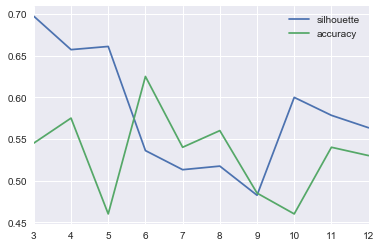

In [93]:
sns.set_style("darkgrid")
scores[['silhouette', 'accuracy']].plot()
plt.show()

In [40]:
best_k = scores['accuracy'].argmax()

In [72]:
bottleneck_sizes = [8,10,12]
k=best_k
for bs in bottleneck_sizes:
    save_name = 'autoencoder_bs{}_2.h5'.format(bs)
    if not os.path.isfile(os.path.join('Keras_save/roofs_DEC',save_name)):
        print("starting training DEC for bottleneck of size "+str(bs))
        c = DeepEmbeddingClustering(n_clusters=10, input_dim=784, alpha = 1.0, bottleneck_size=bs,
                                save_dir='Keras_save/roofs_DEC', save_name=save_name)
        c.initialize(dataset_pp,
                 finetune_iters=10000,
                 layerwise_pretrain_iters=10000,
                 save_autoencoder=True)

starting training DEC for bottleneck of size 8
layerwise pretrain
layer 0
Epoch 1/204
12556/12556 [==============================] - 2s - loss: 18.2728     
Epoch 2/204
12556/12556 [==============================] - 1s - loss: 14.9949     
Epoch 3/204
12556/12556 [==============================] - 1s - loss: 10.8171     
Epoch 4/204
12556/12556 [==============================] - 1s - loss: 9.0446     
Epoch 5/204
12556/12556 [==============================] - 1s - loss: 7.4720     
Epoch 6/204
12556/12556 [==============================] - 1s - loss: 6.1396     
Epoch 7/204
12556/12556 [==============================] - 1s - loss: 5.1819     
Epoch 8/204
12556/12556 [==============================] - 1s - loss: 4.3848     
Epoch 9/204
12556/12556 [==============================] - 1s - loss: 3.7708     
Epoch 10/204
12556/12556 [==============================] - 1s - loss: 2.8931     
Epoch 11/204
12556/12556 [==============================] - 1s - loss: 2.0328     
Epoch 12/204
12556/

In [73]:
scores= pd.DataFrame(columns=['bs', 'k','alpha','accuracy', 'nb_merged_clus'])
bs_to_test = [8,10,12]
k_to_test = [6,9,12]
alpha_to_test = [0.1,1,10]
for bs in bs_to_test:
    for k in k_to_test:
        for alpha in alpha_to_test:
            print("starting training DEC for bs: {}, k: {}, alpha: {}".format(bs,k,alpha))
            c = DeepEmbeddingClustering(n_clusters=k, input_dim=784,
                                        pretrained_weights='autoencoder_bs{}_2.h5'.format(bs),
                                        alpha = alpha, bottleneck_size=bs,
                                        save_dir='Keras_save/roofs_DEC')
            c.initialize(dataset_pp,
                         finetune_iters=10000,
                         layerwise_pretrain_iters=5000)
            c.cluster(dataset_pp, iter_max=3000,tol=0.02)
            accuracy = cluster_acc_with_merging(labels, c.y_pred[acc_sample])
            df = pd.DataFrame([[bs,k,alpha,accuracy[0],len(set(accuracy[1]))]],
                              columns=['bs', 'k','alpha','accuracy', 'nb_merged_clus'])
            scores = scores.append(df)

starting training DEC for bs: 8, k: 6, alpha: 0.1
Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 49)
('Save interval', 2450)
0.0% change in label assignment
3.40873% change in label assignment
7.6776% change in label assignment
3.85473% change in label assignment
1.99904% change in label assignment
Reached tolerance threshold. Stopping training.
starting training DEC for bs: 8, k: 6, alpha: 1
Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 49)
('Save interval', 2450)
0.0% change in label assignment
4.3087% change in label assignment
6.1166% change in label assignment
4.46002% change in label assignment
6.08474% change in label assignment
3.02644% change in label assignment
8.52182% change in label assignment
5.14495% change in label assignment
8.51386% change in label assignment
4.15737% change in label assignment
2.57248% change in label assignment
1.09111% change in 

In [74]:
scores

,bs,k,alpha,accuracy,nb_merged_clus
0,8.0,6.0,0.1,0.550,2.0
0,8.0,6.0,1.0,0.470,2.0
0,8.0,6.0,10.0,0.460,1.0
0,8.0,9.0,0.1,0.515,2.0
0,8.0,9.0,1.0,0.525,3.0
0,8.0,9.0,10.0,0.535,2.0
0,8.0,12.0,0.1,0.520,3.0
0,8.0,12.0,1.0,0.490,3.0
0,8.0,12.0,10.0,0.470,2.0
0,10.0,6.0,0.1,0.660,3.0


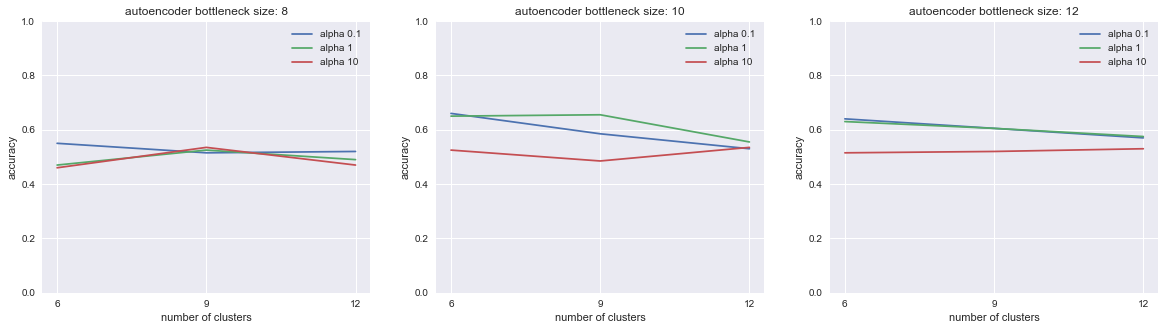

In [75]:
fig, axarr = plt.subplots(1,len(bs_to_test), figsize=(20,5))
for i, bs in enumerate(bs_to_test):
    for alpha in alpha_to_test:
        scores_sel = scores[(scores['bs']==bs)&(scores['alpha']==alpha)]
        axarr[i].plot(scores_sel["k"], scores_sel["accuracy"], label="alpha {}".format(alpha))
    axarr[i].legend(loc="upper right")
    axarr[i].set_xticks(np.arange(min(scores_sel["k"]), max(scores_sel["k"])+1, 3.0))
    axarr[i].set_ylim([0, 1])
    axarr[i].set_title("autoencoder bottleneck size: {}".format(bs))
    axarr[i].set_xlabel('number of clusters')
    axarr[i].set_ylabel('accuracy')
plt.show()

In [76]:
# Save data to pickle file

pickle_file = 'data/roofs_improvement_scores.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'scores': scores
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

#### Final model

In [77]:
c = DeepEmbeddingClustering(n_clusters=k, input_dim=784, save_name='autoencoder_final.h5',
                                alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')

In [ ]:
c.initialize(dataset_pp,
             finetune_iters=100000,
             layerwise_pretrain_iters=50000,
             save_autoencoder=True)

layerwise pretrain
layer 0
Epoch 1/1020
12556/12556 [==============================] - 2s - loss: 18.4439     
Epoch 2/1020
12556/12556 [==============================] - 1s - loss: 17.0555     
Epoch 3/1020
12556/12556 [==============================] - 1s - loss: 12.9024     
Epoch 4/1020
12556/12556 [==============================] - 2s - loss: 9.8948     
Epoch 5/1020
12556/12556 [==============================] - 1s - loss: 7.9327     
Epoch 6/1020
12556/12556 [==============================] - 1s - loss: 6.4792     
Epoch 7/1020
12556/12556 [==============================] - 1s - loss: 5.2340     
Epoch 8/1020
12556/12556 [==============================] - 1s - loss: 4.6351     
Epoch 9/1020
12556/12556 [==============================] - 1s - loss: 3.9964     
Epoch 10/1020
12556/12556 [==============================] - 1s - loss: 3.3243     
Epoch 11/1020
12556/12556 [==============================] - 2s - loss: 3.1097     
Epoch 12/1020
12556/12556 [============================

In [ ]:
k_to_test = range(3,13)
scores = pd.DataFrame(index=k_to_test, columns=['silhouette', 'accuracy', 'nb_merged_clusters'])
for k in k_to_test:
    print("starting training DEC for "+str(k)+' clusters')
    c = DeepEmbeddingClustering(n_clusters=k, input_dim=784, pretrained_weights='autoencoder_final.h5',
                                alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')
    c.initialize(dataset_pp,
                 finetune_iters=100000,
                 layerwise_pretrain_iters=50000)
    c.cluster(dataset_pp, iter_max=50000, tol=0.01)
    
    features = c.encoder.predict(dataset_pp)
    scores.loc[k,'silhouette']=silhouette_score(features, c.y_pred, metric='euclidean')
    acc_res = cluster_acc_with_merging(labels, c.y_pred[acc_sample])
    scores.loc[k,'accuracy']=acc_res[0]
    scores.loc[k,'nb_merged_clusters']=len(set(acc_res[1]))

In [ ]:
# Save data to pickle file

pickle_file = 'data/roofs_final_scores.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'scores': scores
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [88]:
# Load data from pickle file

pickle_file = 'data/roofs_final_scores.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    scores = save['scores']
    del save  # hint to help gc free up memory

In [89]:
scores

,silhouette,accuracy,nb_merged_clusters
3,0.576609,0.545,2
4,0.604143,0.525,3
5,0.678078,0.615,3
6,0.72241,0.575,2
7,0.647387,0.515,2
8,0.708418,0.545,3
9,0.696356,0.5,3
10,0.669376,0.485,3
11,0.679049,0.53,2
12,0.689663,0.62,3


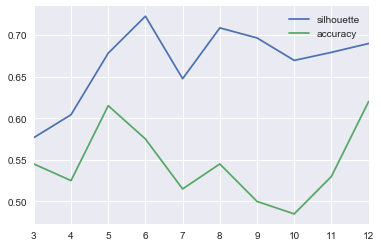

In [90]:
sns.set_style("darkgrid")
scores[['silhouette', 'accuracy']].plot()
plt.show()

#### Chosen clustering

In [20]:
chosen_k = 6

In [43]:
np.random.seed(4) 
c = DeepEmbeddingClustering(n_clusters=chosen_k, input_dim=784, pretrained_weights='autoencoder_final.h5',
                            alpha = 1.0, bottleneck_size=10,
                            save_dir='Keras_save/roofs_DEC')
c.initialize(dataset_pp,
             finetune_iters=100000,
             layerwise_pretrain_iters=50000)
c.cluster(dataset_pp, iter_max=50000, tol=0.02) #0.005
acc_res = cluster_acc_with_merging(labels, c.y_pred[acc_sample])

Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 49)
('Save interval', 2450)
0.0% change in label assignment
5.7582% change in label assignment
10.17044% change in label assignment
8.01211% change in label assignment
6.26792% change in label assignment
7.7015% change in label assignment
11.50844% change in label assignment
3.18573% change in label assignment
2.24594% change in label assignment
5.94935% change in label assignment
3.62377% change in label assignment
3.91048% change in label assignment
2.42912% change in label assignment
1.79994% change in label assignment
Reached tolerance threshold. Stopping training.


In [44]:
dec_clus = c.y_pred
soft_assign = c.p
y_pred = dec_clus[acc_sample]
y_true = labels
merging = cluster_acc_with_merging(y_true, y_pred)[1]
dec_clus_m = np.array([merging[k] for k in dec_clus])
y_pred_m = dec_clus_m[acc_sample]

In [45]:
merging

(0, 0, 0, 1, 1, 2)

In [46]:
cluster_acc_with_merging(y_true, y_pred)[0]

0.63

In [47]:
cluster_acc_with_merging(test_labels, dec_clus[test_acc_sample])[0]

0.62

In [48]:
# Save data to pickle file

pickle_file = 'data/roofs_DEC_results_2.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'dec_clus_m': dec_clus_m,
    'dec_clus': dec_clus,
    'y_pred_dec': y_pred_m,
    'soft_assign': soft_assign
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

#### Several runs

In [136]:

acc_nruns=[]
for i in range(5):
    c = DeepEmbeddingClustering(n_clusters=chosen_k, input_dim=784, pretrained_weights='autoencoder_final.h5',
                                alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')
    c.initialize(dataset_pp,
                 finetune_iters=100000,
                 layerwise_pretrain_iters=50000)
    c.cluster(dataset_pp, iter_max=50000, tol=0.02)
    acc_nruns = acc_nruns +[cluster_acc_with_merging(labels, c.y_pred[acc_sample])]

Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 49)
('Save interval', 2450)
0.0% change in label assignment
5.50335% change in label assignment
10.18637% change in label assignment
7.52628% change in label assignment
4.72284% change in label assignment
4.46002% change in label assignment
9.08729% change in label assignment
2.5008% change in label assignment
4.1972% change in label assignment
4.1733% change in label assignment
3.68748% change in label assignment
2.39726% change in label assignment
2.1424% change in label assignment
2.07869% change in label assignment
1.96719% change in label assignment
Reached tolerance threshold. Stopping training.
Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 49)
('Save interval', 2450)
0.0% change in label assignment
8.01211% change in label assignment
7.66964% change in label assignment
9.15897% change in label assignment
10.31379%

In [137]:
# The accuracies for the same parameters but different runs
acc_nruns

[(0.5, (0, 1, 2, 2, 2, 2)),
 (0.505, (0, 0, 1, 1, 1, 2)),
 (0.51000000000000001, (0, 0, 0, 1, 1, 1)),
 (0.61499999999999999, (0, 0, 1, 1, 1, 1)),
 (0.53500000000000003, (0, 1, 1, 2, 2, 2))]

#### Sensitivity analysis

In [138]:
# Select 1000 points from the dataset including the labelled sample to perform a sensitivity analysis
unlab_ind = [x for x in range(roof_dataset.shape[0]) if not x in acc_sample]
selection_ind = np.random.choice(unlab_ind, 1800, replace=False)
selection_ind = np.unique(np.append(selection_ind,np.sort(acc_sample)))

In [139]:
dataset_ppr = dataset_pp[selection_ind]

In [140]:
c = DeepEmbeddingClustering(n_clusters=k, input_dim=784, save_name='autoencoder_sensit.h5',
                                alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')

In [141]:
c.initialize(dataset_ppr,
             finetune_iters=5000,
             layerwise_pretrain_iters=1000,
             save_autoencoder=True)

layerwise pretrain
layer 0
Epoch 1/142
2000/2000 [==============================] - 1s - loss: 16.9651     
Epoch 2/142
2000/2000 [==============================] - 0s - loss: 13.3344     
Epoch 3/142
2000/2000 [==============================] - 0s - loss: 27.3669     
Epoch 4/142
2000/2000 [==============================] - 0s - loss: 30.4175     
Epoch 5/142
2000/2000 [==============================] - 0s - loss: 27.8806     
Epoch 6/142
2000/2000 [==============================] - 0s - loss: 14.6493     
Epoch 7/142
2000/2000 [==============================] - 0s - loss: 19.2571     
Epoch 8/142
2000/2000 [==============================] - 0s - loss: 13.8072     
Epoch 9/142
2000/2000 [==============================] - 0s - loss: 13.3412     
Epoch 10/142
2000/2000 [==============================] - 0s - loss: 21.8573     
Epoch 11/142
2000/2000 [==============================] - 0s - loss: 12.1224     
Epoch 12/142
2000/2000 [==============================] - 0s - loss: 12.2789    

In [142]:
k_to_test = range(3,13)
scores = pd.DataFrame(index=k_to_test, columns=['silhouette', 'accuracy', 'nb_merged_clusters'])
for k in k_to_test:
    print("starting training DEC for "+str(k)+' clusters')
    c = DeepEmbeddingClustering(n_clusters=k, input_dim=784, pretrained_weights='autoencoder_sensit.h5',
                                alpha = 1.0, bottleneck_size=10,
                                save_dir='Keras_save/roofs_DEC')
    c.initialize(dataset_ppr,
                 finetune_iters=5000,
                 layerwise_pretrain_iters=1000)
    c.cluster(dataset_ppr, iter_max=3000, tol=0.01)
    
    features = c.encoder.predict(dataset_ppr)
    scores.loc[k,'silhouette']=silhouette_score(features, c.y_pred, metric='euclidean')
    acc_res = cluster_acc_with_merging(labels, c.y_pred[1800:2000])
    scores.loc[k,'accuracy']=acc_res[0]
    scores.loc[k,'nb_merged_clusters']=len(set(acc_res[1]))

starting training DEC for 3 clusters
Loading pretrained weights for autoencoder.
Initializing cluster centres with k-means.
('Update interval', 7)
('Save interval', 350)
0.0% change in label assignment
12.1% change in label assignment
14.9% change in label assignment
10.9% change in label assignment
12.9% change in label assignment
11.0% change in label assignment
5.55% change in label assignment
5.9% change in label assignment
13.7% change in label assignment
7.3% change in label assignment
7.45% change in label assignment
9.2% change in label assignment
5.4% change in label assignment
3.7% change in label assignment
3.7% change in label assignment
4.85% change in label assignment
10.0% change in label assignment
4.75% change in label assignment
7.3% change in label assignment
7.05% change in label assignment
6.1% change in label assignment
3.35% change in label assignment
2.2% change in label assignment
4.55% change in label assignment
5.85% change in label assignment
3.75% change in

In [143]:
scores

,silhouette,accuracy,nb_merged_clusters
3,0.620359,0.46,1
4,0.555035,0.46,1
5,0.587634,0.48,2
6,0.691442,0.46,1
7,0.704703,0.46,1
8,0.702743,0.46,1
9,0.68233,0.46,1
10,0.671145,0.46,1
11,0.641588,0.46,1
12,0.572001,0.465,2


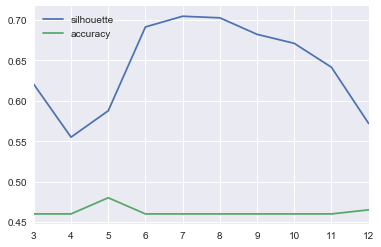

In [146]:
sns.set_style("darkgrid")
scores[['silhouette','accuracy']].plot()
plt.show()

In [145]:
# Save data to pickle file

pickle_file = 'data/roofs_sensit_scores.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'scores': scores
    }
    pickle.dump(save, f, protocol=2)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

#### Analysis of final model results

In [50]:
# Load data from pickle file

pickle_file = 'data/roofs_DEC_results.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    dec_clus = save['dec_clus']
    dec_clus_m = save['dec_clus_m']
    soft_assign = save['soft_assign']
    del save  # hint to help gc free up memory

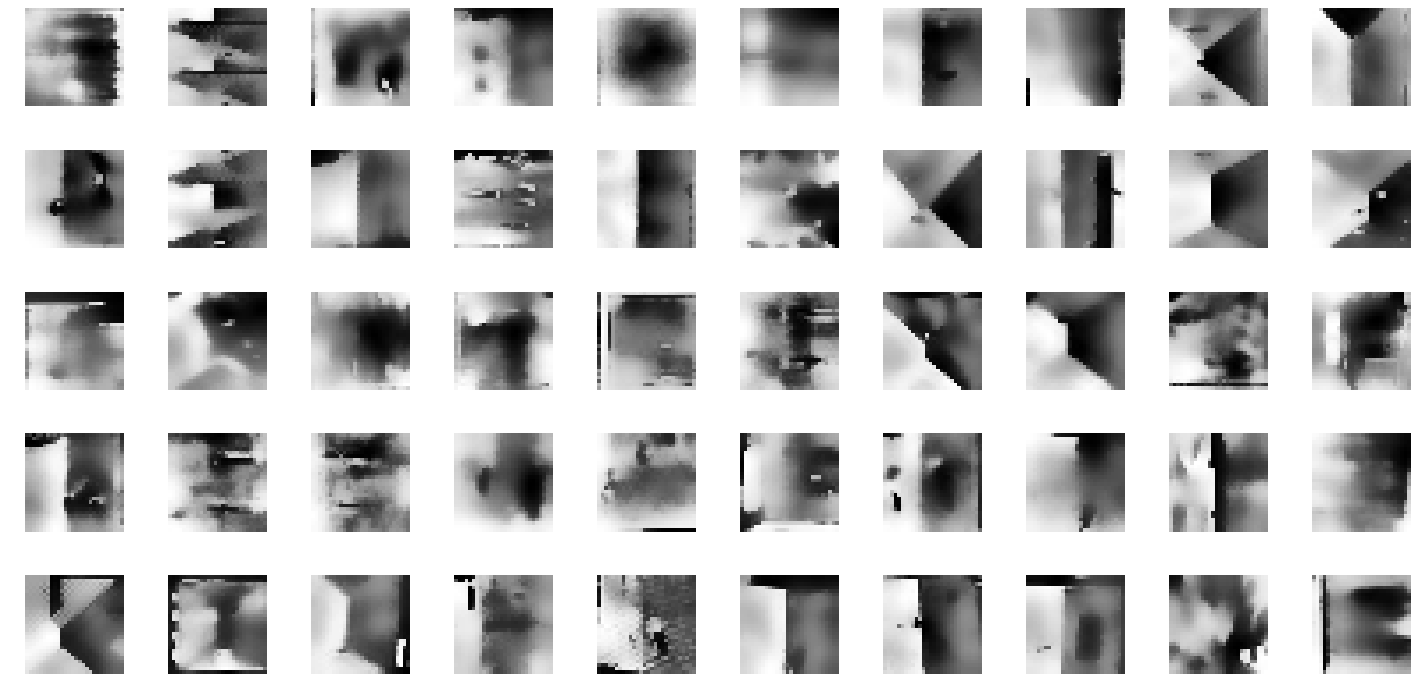

0


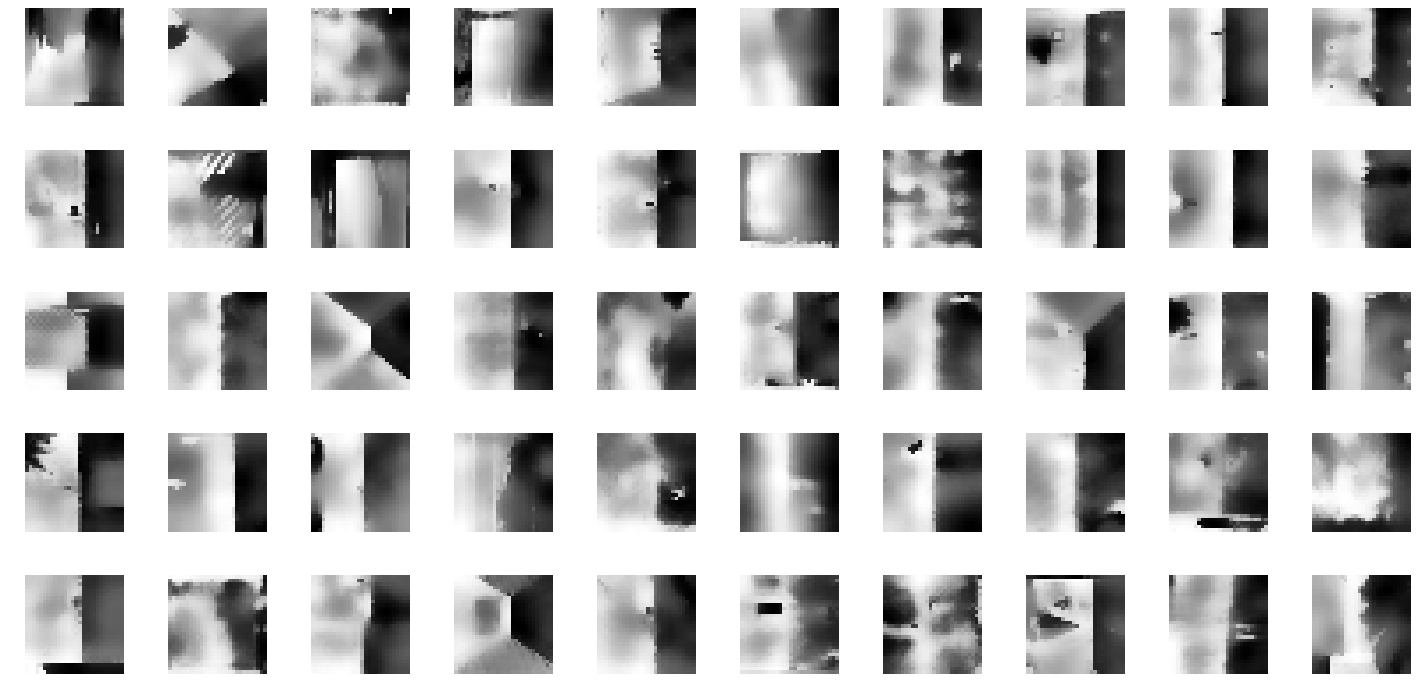

1


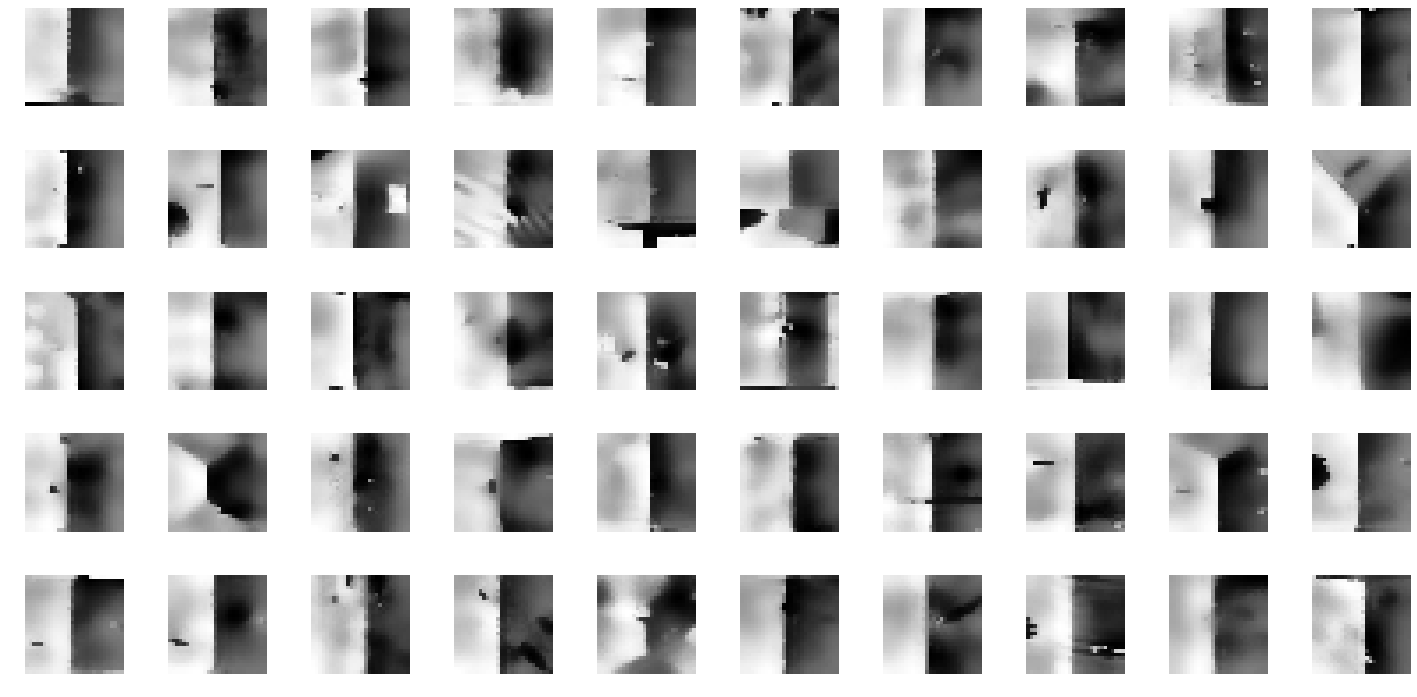

2


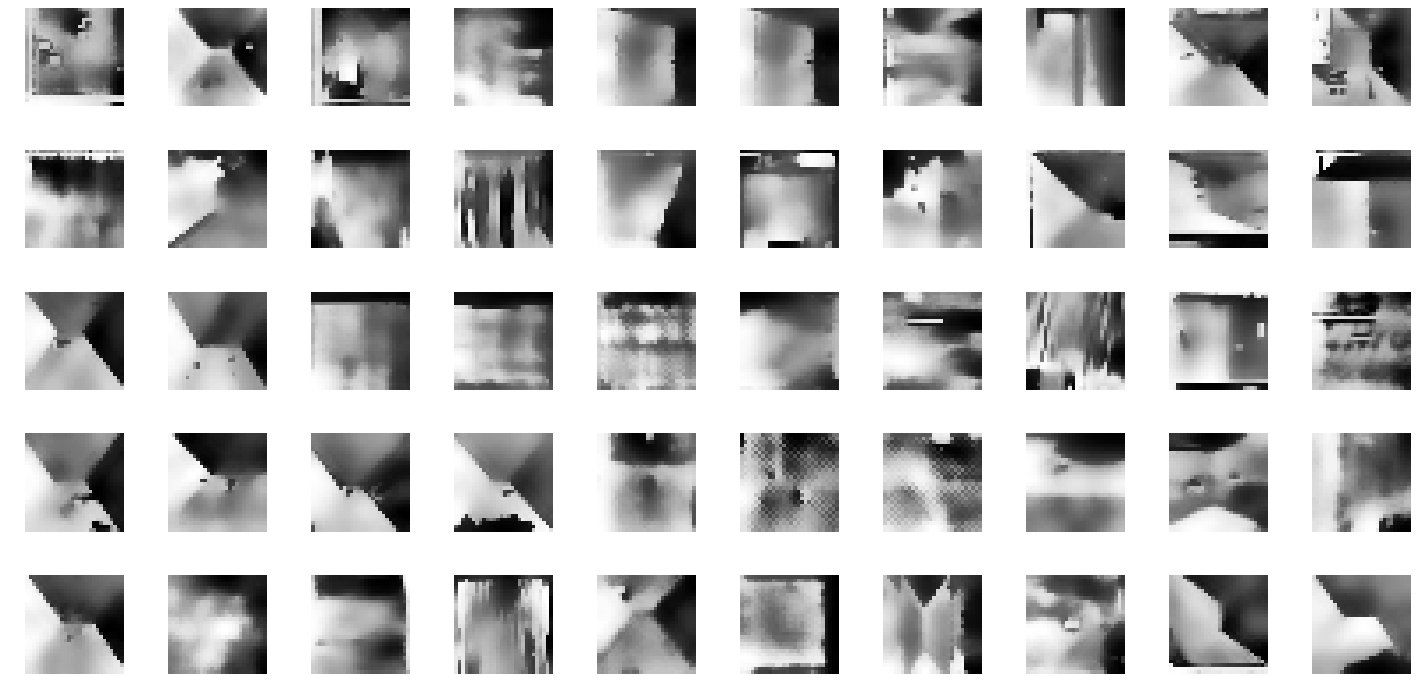

3


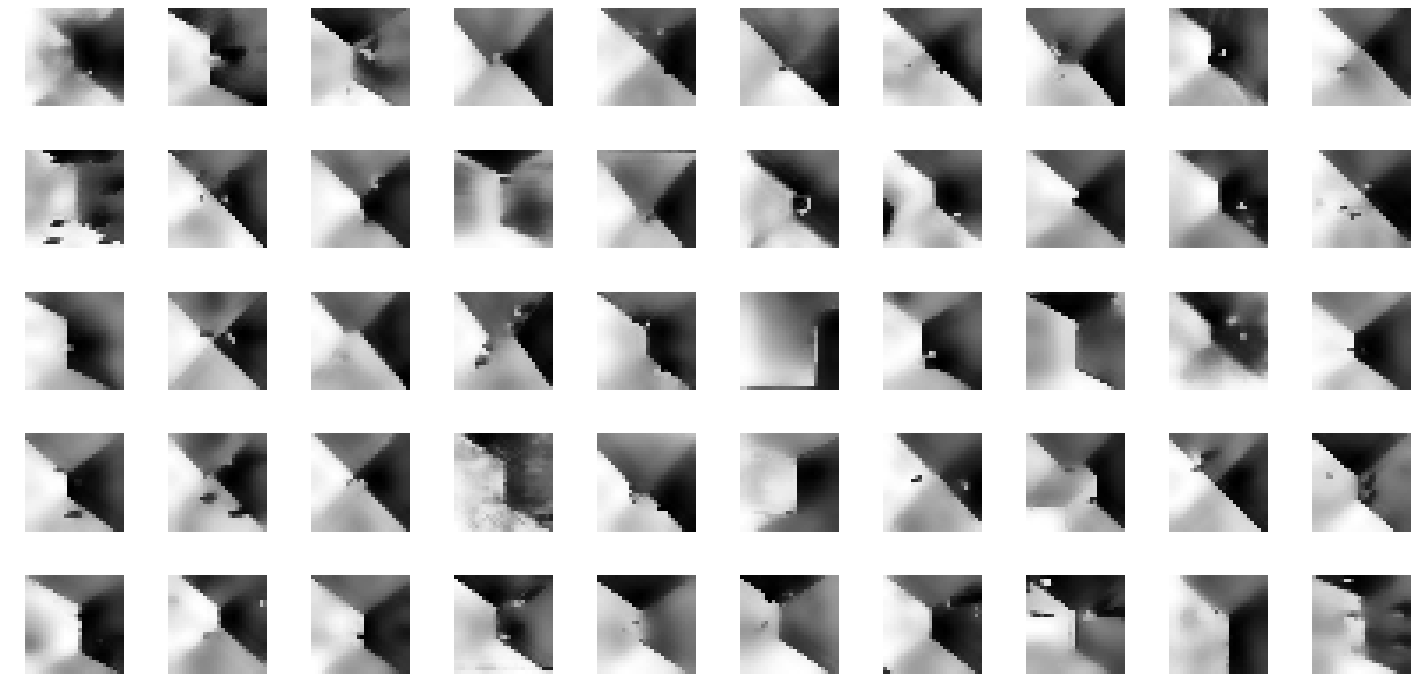

4


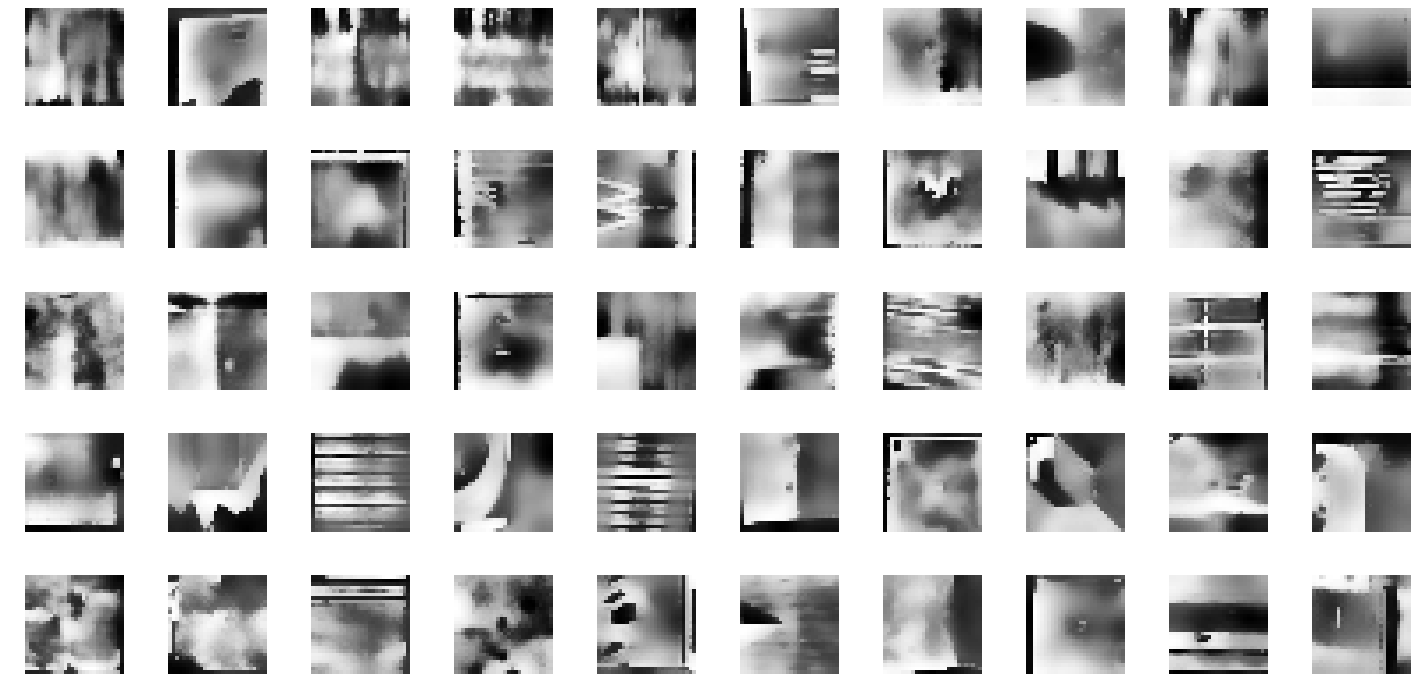

5


In [51]:
for k in list(set(dec_clus)):
    show_dataset(roof_dataset[dec_clus==k], grid_size=(5,10))
    print(k)

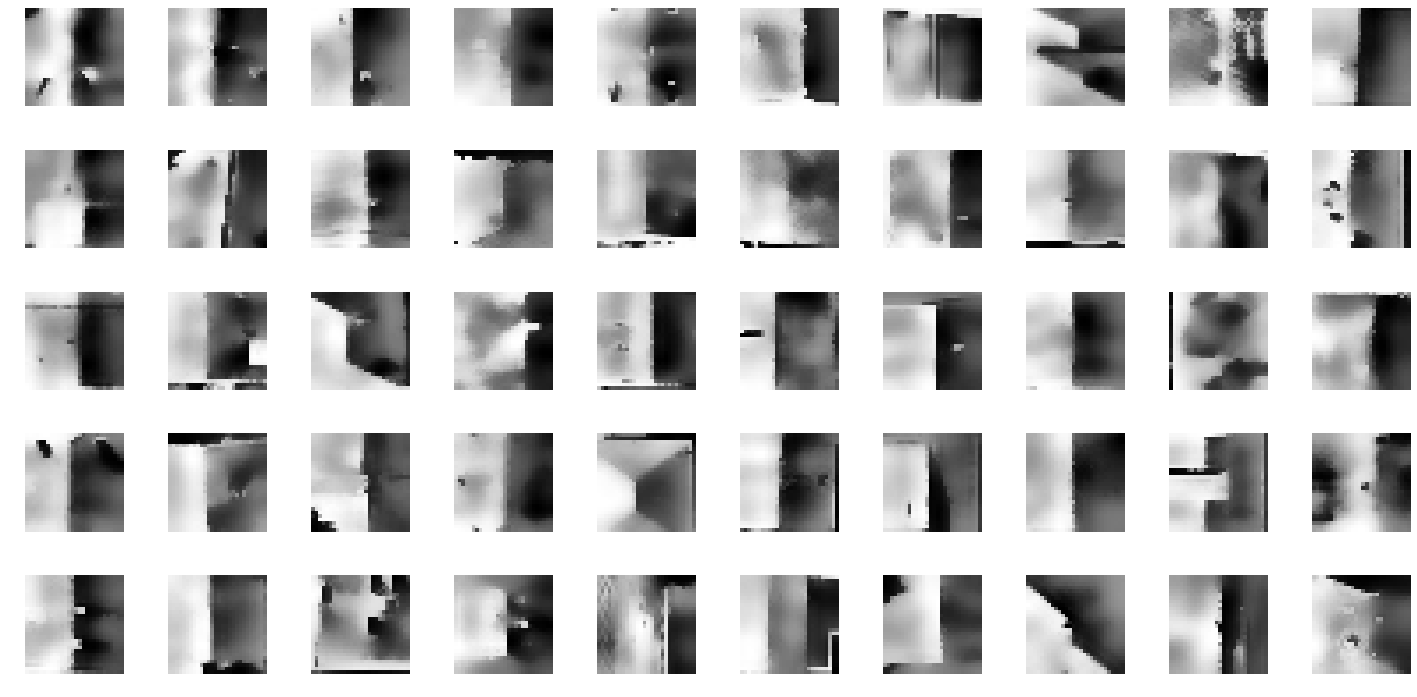

0


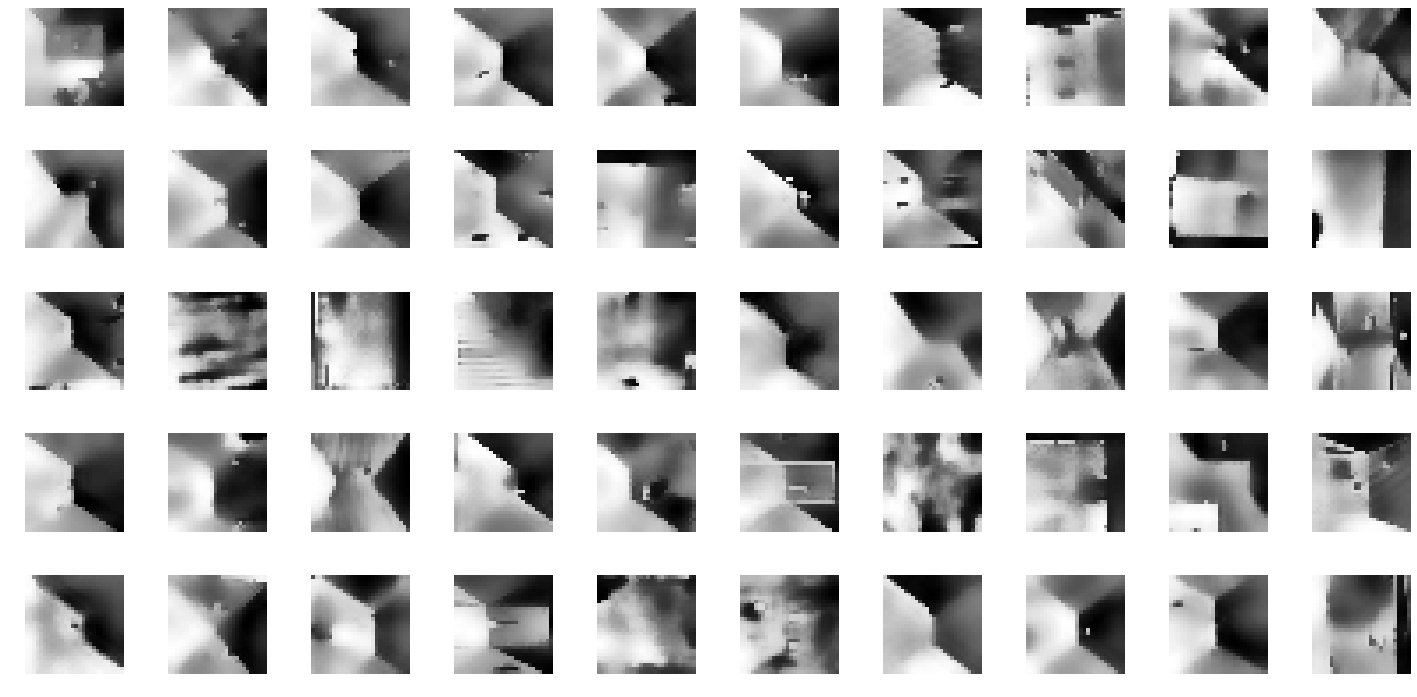

1


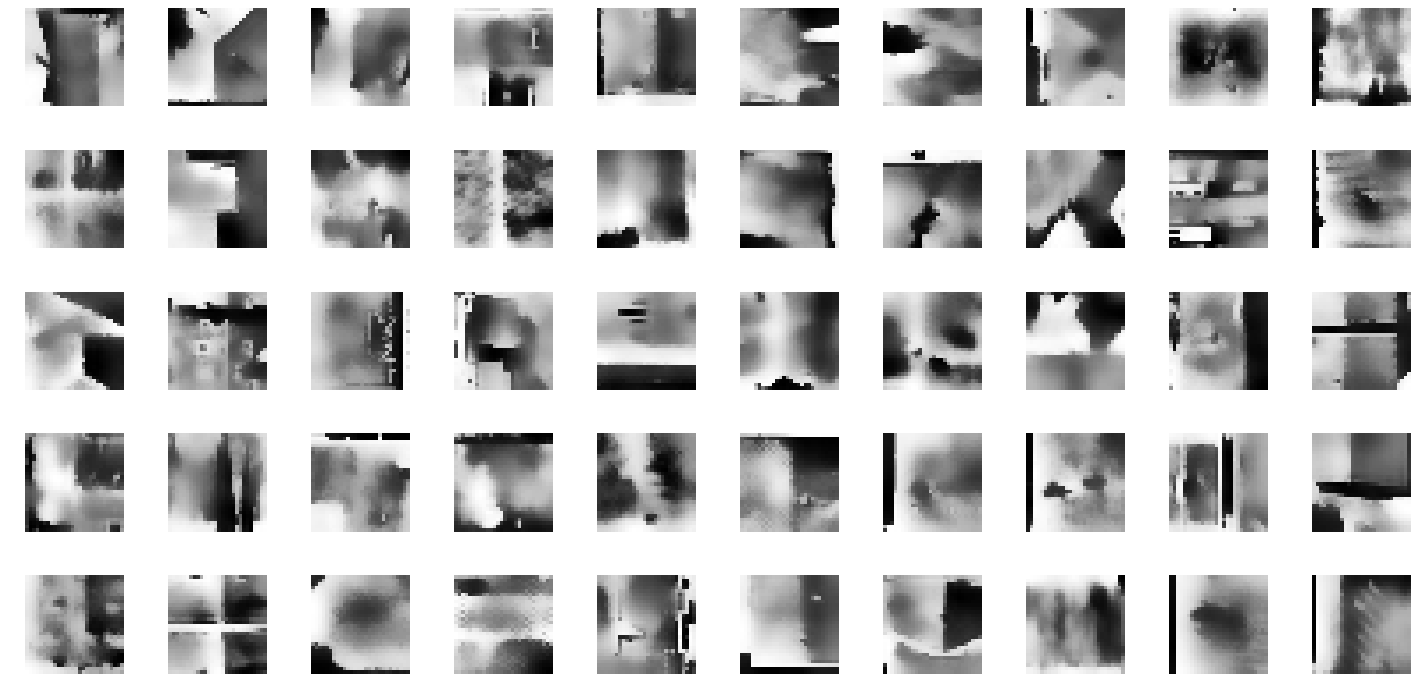

2


In [52]:
for k in list(set(dec_clus_m)):
    roof_dataset_clus_m = roof_dataset[dec_clus_m==k]
    np.random.shuffle(roof_dataset_clus_m)
    show_dataset(roof_dataset_clus_m, grid_size=(5,10))
    print(k)

In [53]:
mean_roofs = np.zeros((len(set(dec_clus)),roof_dataset[0].shape[0],roof_dataset[0].shape[1]))
for k in list(set(dec_clus)):
    mean_roofs[k,:,:]=np.mean(roof_dataset[dec_clus==k],axis=0)

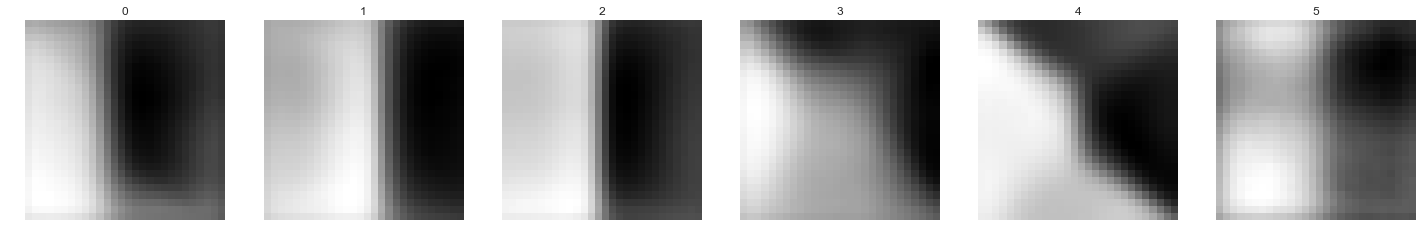

In [54]:
%matplotlib inline
show_dataset1D(mean_roofs, grid_size=6,title=[str(i) for i in range(6)])

In [55]:
mean_roofs_m = np.zeros((len(set(dec_clus_m)),roof_dataset[0].shape[0],roof_dataset[0].shape[1]))
for k in list(set(dec_clus_m)):
    mean_roofs_m[k,:,:]=np.mean(roof_dataset[dec_clus_m==k],axis=0)

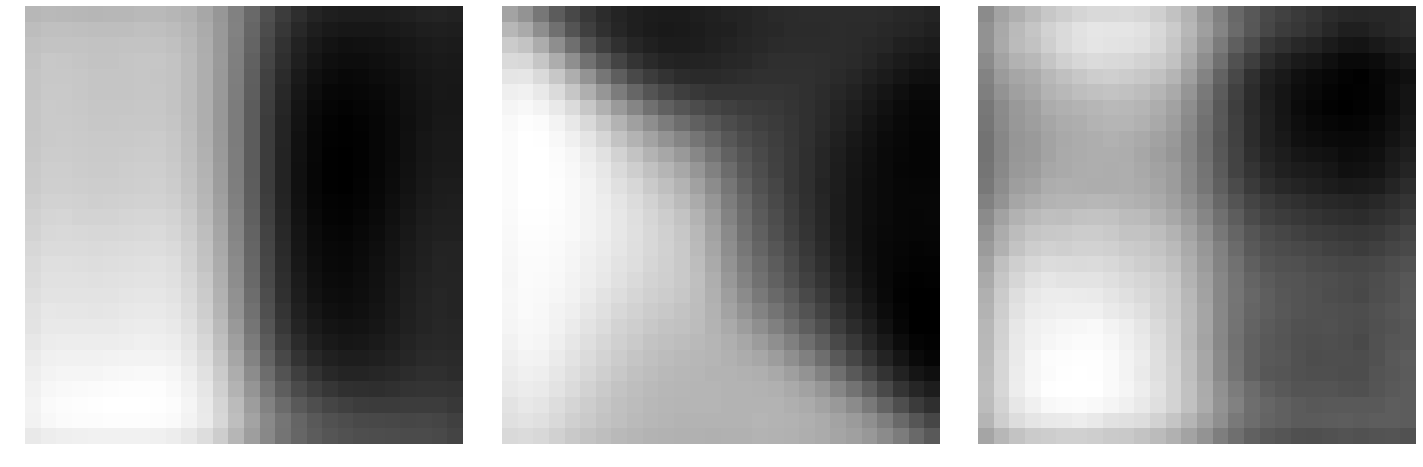

In [56]:
show_dataset1D(mean_roofs_m, grid_size=3)

#### Analysis of soft asignments

In [58]:
clus0_dataset = roof_dataset[dec_clus==4]
clus0_sort = np.argsort(soft_assign[dec_clus==4,4])

In [59]:
clus0_dataset_srt = clus0_dataset[clus0_sort]

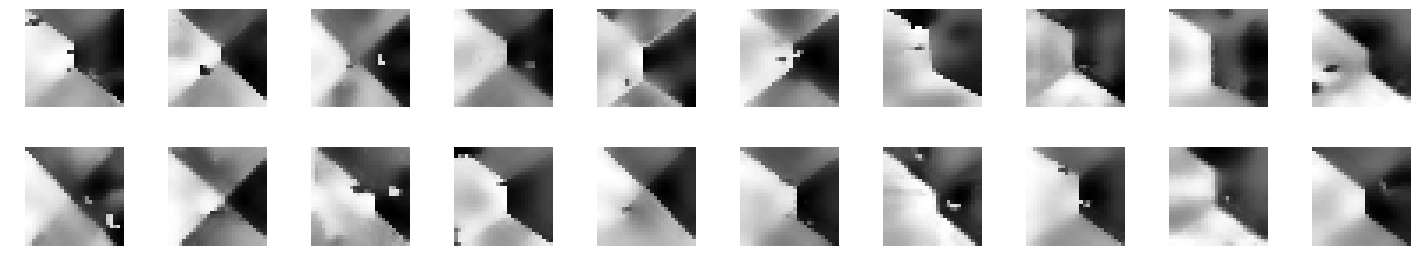

In [62]:
show_dataset(clus0_dataset_srt[1600:1650], grid_size=(2,10))

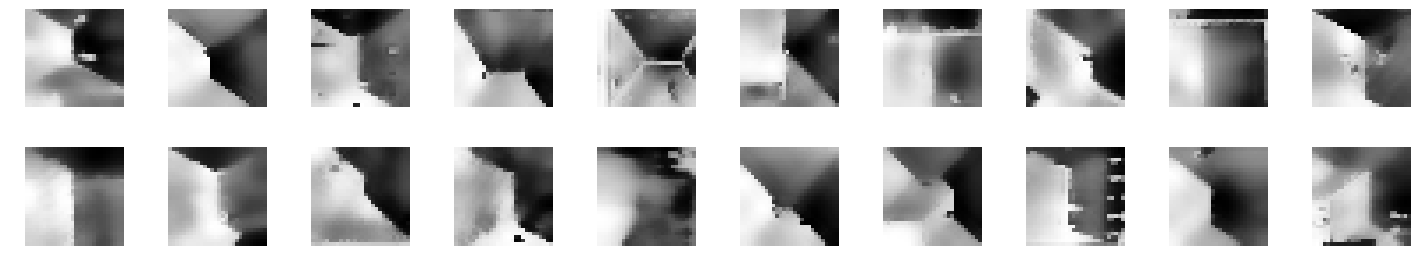

In [63]:
show_dataset(clus0_dataset_srt[0:20], grid_size=(2,10))

In [88]:
sel_clus = [1,2,4]
sel = [clus in sel_clus for clus in dec_clus]
clus_sel_dataset = roof_dataset[sel]
clus_sel_soft_asgn = soft_assign[sel,:][:,sel_clus]

<IPython.core.display.Javascript object>


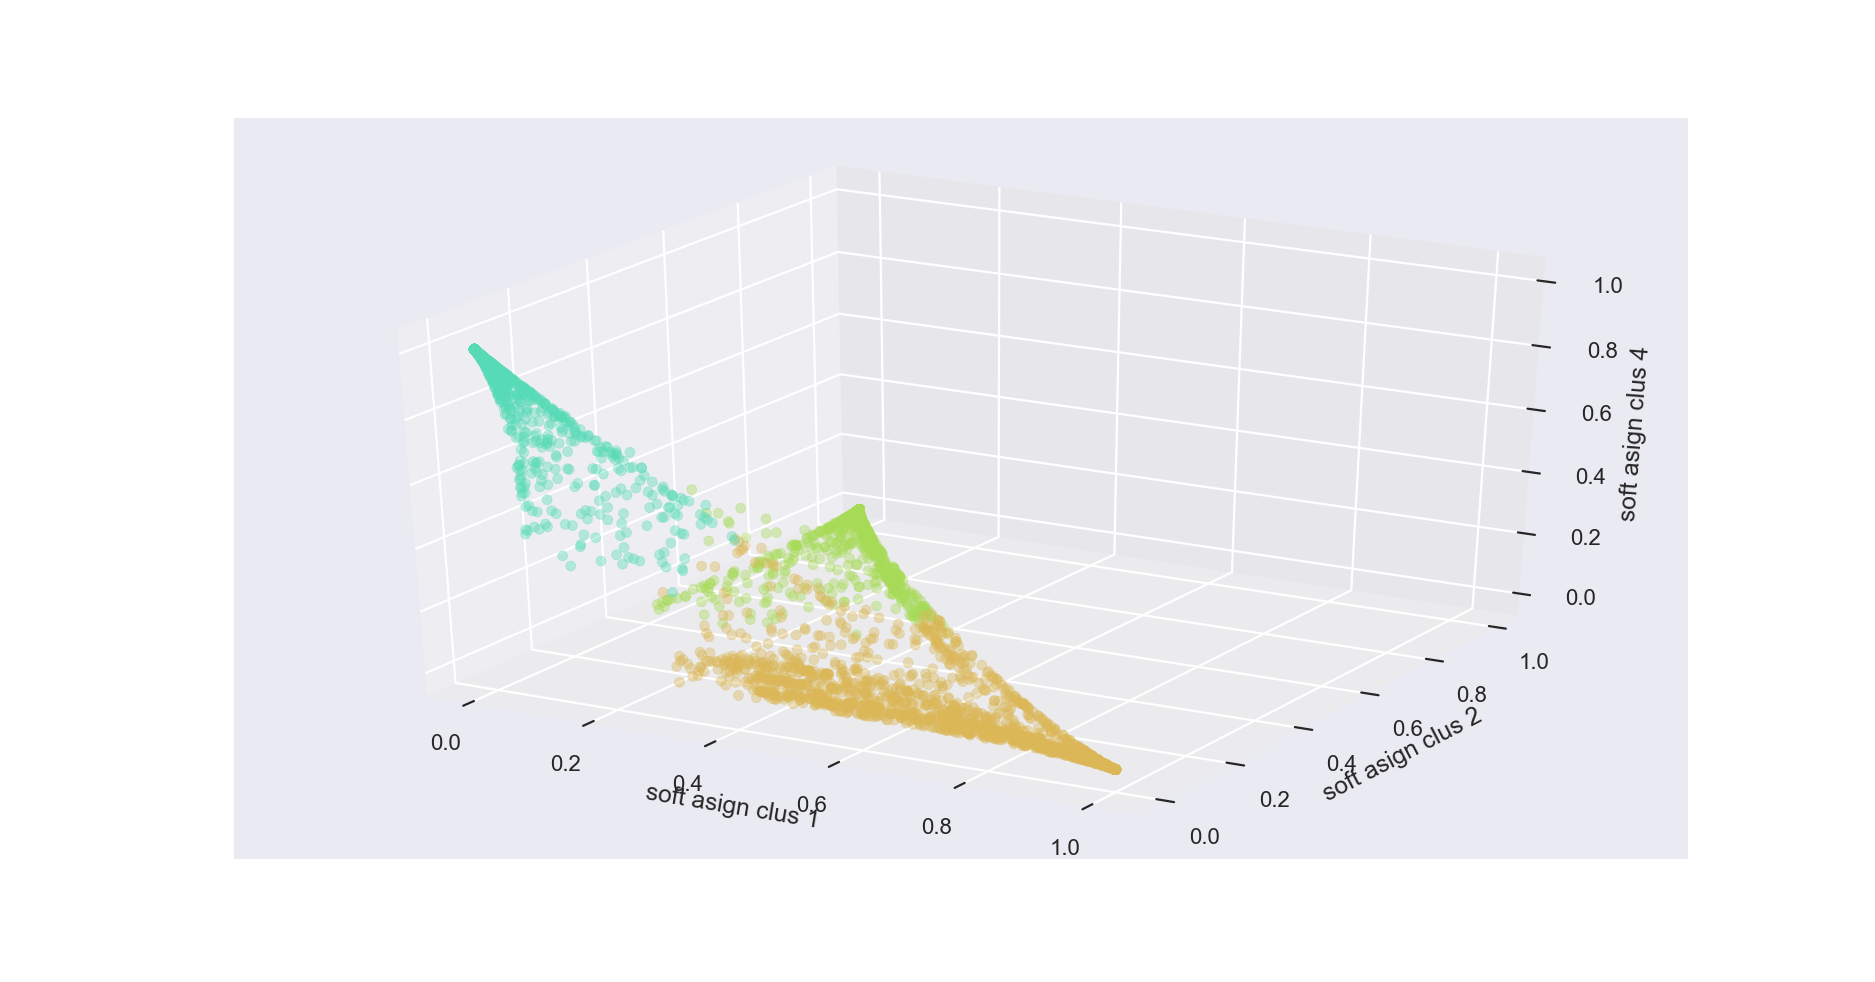

In [92]:
colors = sns.color_palette("hls", 9)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('soft asign clus 1')
ax.set_ylabel('soft asign clus 2')
ax.set_zlabel('soft asign clus 4')
for k in sel_clus:
    ax.scatter(clus_sel_soft_asgn[dec_clus[sel]==k,0],
               clus_sel_soft_asgn[dec_clus[sel]==k,1],
               clus_sel_soft_asgn[dec_clus[sel]==k,2],
               zdir='z',
               alpha=0.4,
               s=20,
               c=colors[k],
               depthshade=True)
plt.show()

0


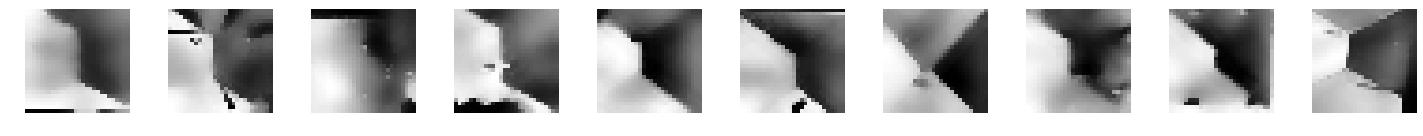

1


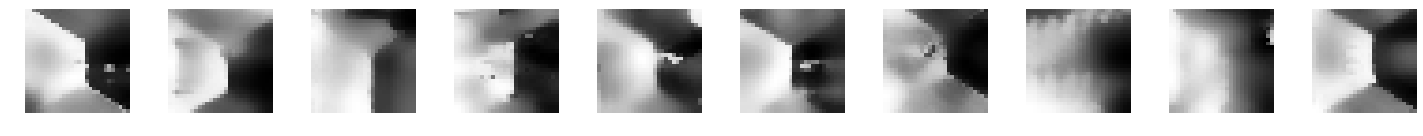

2


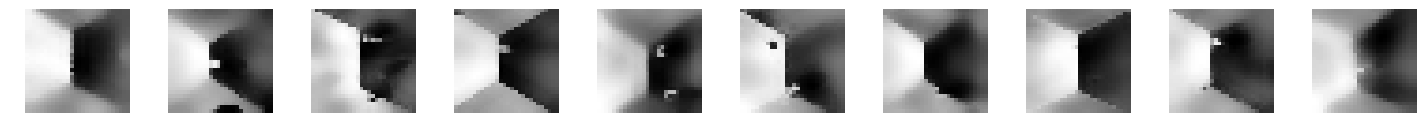

In [76]:
%matplotlib inline
gable_clus = [0,1,2]
hip_clus = 4
for k in gable_clus:
    print(k)
    sel = dec_clus == k
    clus0_sort = np.argsort(soft_assign[sel,hip_clus])[::-1]
    show_dataset1D(roof_dataset[sel][clus0_sort], grid_size=10)

0


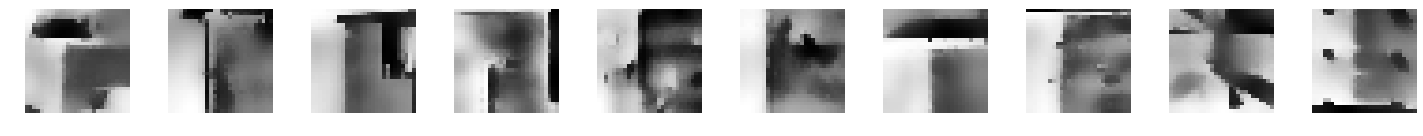

1


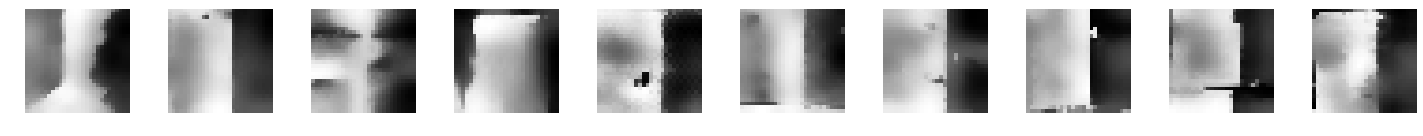

2


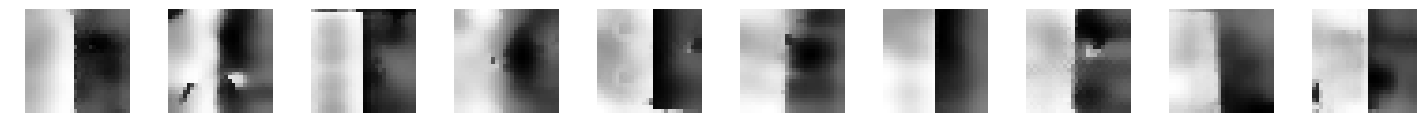

In [77]:
for k in gable_clus:
    print(k)
    sel = dec_clus == k
    clus0_sort = np.argsort(soft_assign[sel,hip_clus])
    show_dataset1D(roof_dataset[sel][clus0_sort], grid_size=10)